# Import libraries

In [44]:
# Basic libraries
import pandas as pd
import numpy as np
from datetime import datetime

# Graphics libraries
import matplotlib.pyplot as plt
import matplotlib.collections
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from itertools import zip_longest

# Libraries to process data and calculate metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
import category_encoders as ce
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_recall_curve,auc, roc_auc_score, roc_curve, recall_score, \
classification_report,accuracy_score, fbeta_score, make_scorer, average_precision_score, precision_score, f1_score

# Import pickle and joblib packages
import pickle as pkl
from joblib import dump, load

# Import torch
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import Optimizer

# Import from skorch 
from skorch.callbacks import EpochScoring, EarlyStopping
from skorch import NeuralNetClassifier, NeuralNetBinaryClassifier

## Define auxiliary functions

### Define AdaBound Optimizer class (Used in MLP neural network)

In [45]:

class AdaBound(Optimizer):
    """  AdaBound code from https://github.com/Luolc/AdaBound/blob/master/adabound/adabound.py
    Implements AdaBound algorithm.
    It has been proposed in `Adaptive Gradient Methods with Dynamic Bound of Learning Rate`_.
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): Adam learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        final_lr (float, optional): final (SGD) learning rate (default: 0.1)
        gamma (float, optional): convergence speed of the bound functions (default: 1e-3)
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsbound (boolean, optional): whether to use the AMSBound variant of this algorithm
    .. Adaptive Gradient Methods with Dynamic Bound of Learning Rate:
        https://openreview.net/forum?id=Bkg3g2R9FX
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        super(AdaBound, self).__init__(params, defaults)

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))

    def __setstate__(self, state):
        super(AdaBound, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsbound', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'Adam does not support sparse gradients, please consider SparseAdam instead')
                amsbound = group['amsbound']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsbound:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsbound:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsbound:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1

                # Applies bounds on actual learning rate
                # lr_scheduler cannot affect final_lr, this is a workaround to apply lr decay
                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state['step'] + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state['step']))
                step_size = torch.full_like(denom, step_size)
                step_size.div_(denom).clamp_(lower_bound, upper_bound).mul_(exp_avg)

                p.data.add_(-step_size)

        return loss
    
    
def make_segments(x, y):
    '''
    Create list of line segments from x and y coordinates,
    in the correct format for LineCollection:
    an array of the form
    numlines x (points per line) x 2 (x and y) array
    '''

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    return segments




### Define functions necessary for the classifiers scores and overal results from plots or graphs

In [46]:
def div0( a, b ):
    """ ignore / 0, div0( [-1, 0, 1], 0 ) -> [0, 0, 0] """
    with np.errstate(divide='ignore', invalid='ignore'):
        c = np.true_divide( a, b )
        c[~np.isfinite( c )] = 0  # -inf inf NaN
    return c


def euclidean_dist(list_a,list_b):
    return np.array([[ np.linalg.norm(i-j) for j in list_b] for i in list_a])

def colorline(x, y, z=None, axes=None,
              cmap=plt.get_cmap('coolwarm'),
              norm=plt.Normalize(0.0, 1.0), linewidth=3, alpha=1.0,
              **kwargs):
    '''
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    '''

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if isinstance(z, numbers.Real):
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = matplotlib.collections.LineCollection(
        segments, array=z, cmap=cmap, norm=norm,
        linewidth=linewidth, alpha=alpha, **kwargs
    )

    if axes is None:
        axes = plt.gca()

    axes.add_collection(lc)
    axes.autoscale()

    return lc


def plot_precision_recall_vs_threshold(precision, recall, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precision[:-1], "b--", label="Precision")
    plt.plot(thresholds, recall[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
    
# def adjusted_classes(y_scores, t):
#     """
#     This function adjusts class predictions based on the prediction threshold (t).
#     Will only work for binary classification problems.
#     """
#     return [1 if y >= t else 0 for y in y_scores]



def plot_pr_auc_thresholds(precision, recall, thresh, y_test, y_pred_proba, plot_type='',savefig='No'):
    
    pr_df = pd.DataFrame(zip_longest(precision, recall, thresh),columns = ["Precision","Recall","Threshold"])

    # convert to f score
    fscore = div0((2 * precision * recall), (precision + recall)) 
    # locate the index of the largest f score
    ix = np.argmax(fscore)


    fig = px.area(pr_df, x='Precision',y='Recall',hover_data=['Threshold'],title='PR-AUC (' + plot_type + ')')

    
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig.add_shape(type='line',
                x0=0,
                y0=no_skill,
                x1=1,
                y1=no_skill,
                line=dict(color='Black',dash= 'dash'),
                xref='x',
                yref='y'
    )
    
    fig.add_trace(go.Scatter(
        x=[0.5],
        y=[no_skill+0.05],
        mode="text",
        text=["Random Classifier:(P:N = 1:9)"],
        textposition="bottom center",
        textfont=dict(
            family="Arial Black",
            size=14,
            color="Black"
        )
    ))
    
    for i in range(len(pr_df)):
        if i%(len(pr_df)/20)==0:
            fig.add_annotation(x=pr_df.iloc[i][0],y=pr_df.iloc[i][1],
                               text=f'Thresh={pr_df.iloc[i][2]:.2f}',
                               showarrow=True,arrowhead=1)

    fig.add_annotation(x=pr_df.iloc[ix][0],y=pr_df.iloc[ix][1],
                       text=f'Optimal Thresh={fscore[ix]:.2f}', 
                       showarrow=True,arrowcolor='red',
                       bgcolor='white',bordercolor='black',borderwidth=1,
                       font=dict(size=16,color="#FF0000"))
    
    fig.add_annotation(x=0.5,y=0.5,text=f'AUC={average_precision_score(y_test, y_pred_proba):.2f}', 
                       showarrow=False,font=dict(size=20,color="#FF0000",family="Arial Black"))
    
    fig.layout.update(showlegend=False)
    
    if savefig=='Yes':
        fig.savefig('plot_precision_recall' + plot_type + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
        
    fig.show()


def precision_recall_threshold(p, r, thresholds, y_test, y_pred_proba, t=0.5, plot_type='',savefig='No'):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    font = {'family': 'Arial',
        'color':  'red',
        'weight': 'normal',
        'size': 18,
        }
    # convert to f score
    fscore = div0((2 * precision * recall), (precision + recall)) 
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    
    # plot the curve
    plt.figure(figsize=(10,10))
    plt.title('PR-AUC (' + plot_type + ')')
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', color='black')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.text(0.0, no_skill + 0.03, 'Random Classifier:(P:N = 1:9)', color='black',fontsize=16)
    plt.text(0.45, 0.3, 'AUC = %s'% (round(average_precision_score(y_test, y_pred_proba),2)), fontdict=font)
    plt.text(r[ix], p[ix]+0.03,'Optimized Threshold', color='red',fontsize=14)
    plt.scatter(r[ix], p[ix], marker='o', color='red')
    plt.ylim([-0.05, 1.05]);
    plt.xlim([-0.05, 1.05]);
    plt.xlabel('Recall',fontsize=16);
    plt.ylabel('Precision',fontsize=16);
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
             
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    

def plot_roc_auc_thresholds(fpr, tpr, thresh, y_test, y_pred_proba, plot_type='',savefig='No'):
    
    roc_df = pd.DataFrame(zip_longest(fpr, tpr, thresh),columns = ["FPR","TPR","Threshold"])

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    

    fig = px.area(roc_df, x='FPR',y='TPR',hover_data=['Threshold'],title='ROC-AUC (' + plot_type + ')')

    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig.add_shape(type='line',
                x0=0,
                y0=0,
                x1=1,
                y1=1,
                line=dict(color='Black',dash= 'dash'),
                xref='x',
                yref='y'
    )
    
    fig.add_trace(go.Scatter(
        x=[0.25],
        y=[0.1],
        mode="text",
        text=["Random Classifier:(P:N = 1:9)"],
        textposition="bottom center",
        textfont=dict(
            family="Arial Black",
            size=14,
            color="Black"
        )
    ))
    
    for i in range(len(roc_df)):
        if i%(len(roc_df)/20)==0:
            fig.add_annotation(x=roc_df.iloc[i][0],y=roc_df.iloc[i][1],
                               text=f'Thresh={roc_df.iloc[i][2]:.2f}',
                               showarrow=True,arrowhead=1)

    fig.add_annotation(x=roc_df.iloc[ix][0],y=roc_df.iloc[ix][1],
                       text=f'Optimal Thresh={gmeans[ix]:.2f}', 
                       showarrow=True,arrowcolor='red',
                       bgcolor='white',bordercolor='black',borderwidth=1,
                       font=dict(size=16,color="#FF0000"))

    fig.add_annotation(x=0.5,y=0.5,text=f'AUC={roc_auc_score(y_test, y_pred_proba):.2f}', 
                       showarrow=False,font=dict(size=20,color="#FF0000",family="Arial Black"))

    fig.layout.update(showlegend=False)
    
    if savefig=='Yes':
        fig.savefig('plot_roc_auc_' + plot_type + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')
        
    fig.show()

    

    
def plot_confusion_matrix(cf_matrix, target_names=None,plot_type='',savefig='No'):

    group_names = ['TN', 'FP', 'FN', 'TP']
    group_counts = ["{0:.0f}".format(value) for value in 
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in 
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in 
              zip(group_names,
                  group_counts,
                  group_percentages)
             ]
    labels = np.asarray(labels).reshape(2, 2)

    fig = plt.figure(figsize = (14, 8))
    res = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues',  annot_kws={"size": 14})
    
    if target_names:
        tick_marks = range(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)
    
    plt.xticks([0.5,1.5], target_names,va='center')
    plt.yticks([0.5,1.5], target_names,va='center')

    precision = cf_matrix[1, 1] / sum(cf_matrix[:, 1])
    recall    = cf_matrix[1, 1] / sum(cf_matrix[1,:])
    accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
    f1_score  = 2 * precision * recall / (precision + recall)
    stats_text = "\n\n\nPrecision.={:0.3f}\nRecall={:0.3f}\n\nAccuracy={:0.3f}\nF1 Score={:0.3f}".format(
        precision, recall, accuracy, f1_score)
    plt.xlabel('Predicted label {}'.format(stats_text),fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.show()
    if savefig=='Yes':
        fig.savefig('plot_confusion_matrix_' + plot_type + '_' + datetime.now().strftime("%Y_%m_%d_%H_%M_%S") + '.png')

### Pre process data and generate a test set scaled based on the original test set (test.csv)

In [47]:
# Transform input variables

def transform_input(X_train, X_test, quant_var, nom_var, onehot_var, df):
    # Reconstruct features set
    X_train_df = pd.DataFrame(X_train, columns = df.drop('y', axis=1).columns)
    X_test_df = pd.DataFrame(X_test, columns = df.drop('y', axis=1).columns)
    
    # Define quantitative variables
    train_df_quant = X_train_df[quant_var]
    test_df_quant = X_test_df[quant_var]
    
    # Define Ordinal Encoder for Default, Housing, Loan variables
    ordn = OrdinalEncoder(categories=[['yes','unknown','no']]*3)    
    # Fit
    ordn.fit(X_train_df[['default','housing', 'loan']]) #train_df_ordinal[['default','housing', 'loan']])
    # Transform
    X_train_ord1 = ordn.transform(X_train_df[['default','housing', 'loan']])
    X_test_ord1 = ordn.transform(X_test_df[['default','housing', 'loan']])
    
    
    # Define Ordinal Encoder for Poutcome variable
    ordn = OrdinalEncoder(categories=[['failure','nonexistent','success']])
    # Fit
    ordn.fit(np.array(X_train_df['poutcome']).reshape(-1,1))
    # Transform
    X_train_ord2 = ordn.transform(X_train_df[['poutcome']])
    X_test_ord2 = ordn.transform(X_test_df[['poutcome']])
    
     # Define Ordinal Encoder for Contact variable
    ordn = OrdinalEncoder(categories=[['cellular','telephone']])
    # Fit
    ordn.fit(np.array(X_train_df['contact']).reshape(-1,1))
    # Transform
    X_train_ord3 = ordn.transform(X_train_df[['contact']])
    X_test_ord3 = ordn.transform(X_test_df[['contact']])
    
    # Define Ordinal Encoder for Contact variable
    ordn = OrdinalEncoder(categories=[['mon','tue','wed','thu','fri']])
    # Fit
    ordn.fit(np.array(X_train_df['day_of_week']).reshape(-1,1))
    # Transform
    X_train_ord4 = ordn.transform(X_train_df[['day_of_week']])
    X_test_ord4 = ordn.transform(X_test_df[['day_of_week']])
    
    
    # Define Ordinal Encoder for Month variable
    ordn = ce.OrdinalEncoder(cols=['month'], return_df=True, mapping = [{
                           'col': 'month', 'mapping': { 
                           'jan': 1, 'feb': 2, 'mar': 3, \
                           'apr': 4, 'may': 5, 'jun': 6,  'jul': 7, \
                           'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}}])

    # Fit
    ordn.fit(X_train_df['month'])
    # Transform
    X_train_ord5 = ordn.transform(X_train_df[['month']])
    X_test_ord5 = ordn.transform(X_test_df[['month']])
    
    
    # Define OneHot Encoder
    ohe = OneHotEncoder(handle_unknown='error') #,drop='first',
    # Fit
    ohe.fit(X_train_df[nom_var])
    onehot_list = ohe.get_feature_names(nom_var)
    # Transform
    X_train_nom = ohe.transform(X_train_df[nom_var])
    X_test_nom = ohe.transform(X_test_df[nom_var])
    
    # Create dataframe (training)
    train_df_ord1 = pd.DataFrame(X_train_ord1, columns = ['default','housing', 'loan'])
    train_df_ord2 = pd.DataFrame(X_train_ord2, columns = ['poutcome'])
    train_df_ord3 = pd.DataFrame(X_train_ord3, columns = ['contact'])
    train_df_ord4 = pd.DataFrame(X_train_ord4, columns = ['day_of_week'])
    train_df_ord5 = pd.DataFrame(X_train_ord5, columns = ['month'])
    train_df_nom =  pd.DataFrame(X_train_nom.toarray(), columns = list(onehot_list))
    
    # Create dataframe (test)
    test_df_ord1 = pd.DataFrame(X_test_ord1, columns = ['default','housing', 'loan'])
    test_df_ord2 = pd.DataFrame(X_test_ord2, columns = ['poutcome'])
    test_df_ord3 = pd.DataFrame(X_test_ord3, columns = ['contact'])
    test_df_ord4 = pd.DataFrame(X_test_ord4, columns = ['day_of_week'])
    test_df_ord5 = pd.DataFrame(X_test_ord5, columns = ['month'])
    test_df_nom =  pd.DataFrame(X_test_nom.toarray(), columns = list(onehot_list))

    # Concatenate dataframes (quantitative / categorical) for training / test
    train_frames = [train_df_ord1, train_df_ord2, train_df_ord3, train_df_ord4, 
                    train_df_ord5, train_df_nom, train_df_quant]
    test_frames = [test_df_ord1, test_df_ord2, test_df_ord3, test_df_ord4, 
                   test_df_ord5, test_df_nom, test_df_quant]
    train_df_trans = pd.concat(train_frames, axis=1)
    test_df_trans = pd.concat(test_frames, axis=1)
    
    #print(X_train_trans, X_test_trans)
    return train_df_trans, test_df_trans
    
    
# Transform target variable    
def transform_target(y_train, y_test):
    le = LabelEncoder()
    le.fit(np.ravel(y_train))
    y_train_trans = le.transform(np.ravel(y_train))
    y_test_trans = le.transform(np.ravel(y_test))
    return y_train_trans, y_test_trans

def pre_process():
    df = pd.read_csv('bank-additional-full.csv', delimiter=';')
    df.drop(columns=['duration'],inplace=True,errors='ignore')
    quant_var = ['age','campaign','pdays','previous','emp.var.rate',
                 'cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
    categ_var = ['default','housing','loan','poutcome','contact','job',
                 'marital','education','month','day_of_week']
    # Create dummy variables
    nom_var = ['job','marital','education'] 
    df_nom_var = pd.get_dummies(df[nom_var], columns=nom_var, drop_first=True)

    # Save name of the onehot columns
    onehot_var = df_nom_var.columns
    # Define features and target variables accordingly
    X = df.drop('y', axis=1).values
    y = df['y'].values
    y = y.reshape(y.shape[0], 1)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    
    # Transform input data (X)
    train_df_trans, test_df_trans = transform_input(X_train_raw, X_test_raw, quant_var, nom_var, onehot_var, df)

    # Transform output data (y)
    y_train_trans, y_test_trans = transform_target(y_train, y_test)

    # Prepare inputs
    X_train = np.array(train_df_trans)
    X_test_unscaled = np.array(test_df_trans)

    # Reshape target variable
    y_train = y_train_trans.reshape(-1,1)
    y_test = y_test_trans.reshape(-1,1)
    
    # Scale variable
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test_unscaled)
    
    return X_test, y_test, X_test_unscaled

## Run data pre processing to generate test set

In [48]:
X_test, y_test, X_test_unscaled = pre_process()

C:\Users\user\AppData\Local\Programs\Python\Python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [49]:
#X_train.shape, y_train.shape, X_test.shape, y_test.shape

In [50]:
# df_X_test_scaled = pd.DataFrame(data=X_test,columns=test_cols)
# df_y_test_scaled = pd.DataFrame(data=y_test,columns=['y'])

In [51]:
# frames_test = [df_X_test_scaled,df_y_test_scaled]
# df_test = pd.concat(frames_test, axis=1)

In [52]:
# df_test.to_csv('test.csv',index=False)

## Load test dataframe and convert to array

In [53]:
#df_test_csv = pd.read_csv('test.csv')

In [54]:
#df_test_csv.head()

### Create feature and target arrays for test set

In [55]:
# X_test_comparison = np.array(df_test_csv.iloc[:,:-1])
# y_test_comparison = np.array(df_test_csv.iloc[:,-1]).reshape(-1,1)

## Define best models based on saved filenames (joblib)

In [56]:
# Define best models filenames to load best models
mlp_best_model_filename =  'mlp_best_network.pkl' #'mlp_best_model.joblib'
svm_best_model_filename = 'svm_best_model.joblib' #'svm_best_model.pkl

# Define Optimizer and history files
mlp_best_model_optimizer = 'mlp_opt.pkl' 
mlp_best_model_history = 'mlp_history.json' 

# Perform evaluation of MLP best model

## Define NN architecture as previously defined

In [57]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=48, output_dim=2, dropout=0.5):
        super(NeuralNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.fcl1 = nn.Linear(input_dim, hidden_dim)
        self.fcl2 = nn.Linear(hidden_dim, round(hidden_dim/2))
        self.output = nn.Linear(round(hidden_dim/2), output_dim)
        
        #self.relu = nn.ReLU() # ReLU activation function
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim) # Batch Normalization (First Layer)
        self.batchnorm2 = nn.BatchNorm1d(round(hidden_dim/2)) # Batch Normalization (Second Layer)
        self.dropout = nn.Dropout(p=dropout) # Dropout
    
        # Initialize weights with Uniform distribution (First Layer)
        nn.init.uniform_(self.fcl1.weight)
        nn.init.zeros_(self.fcl1.bias)
        
        # Initialize weights with Xavier Uniform distribution (Second Layer)
        nn.init.uniform_(self.fcl2.weight)
        nn.init.zeros_(self.fcl2.bias)
        
    def forward(self, x):

        x = self.dropout(F.elu(self.batchnorm1(self.fcl1(x)))) # First Hidden Layer 
        x = self.dropout(F.elu(self.batchnorm2(self.fcl2(x)))) # Second Hidden Layer
        x = self.output(x)                                      # Output Layer

        return x 

## Load hyperparameters (best model) from file

In [58]:
#mlp_clf = load('mlp_best_model.joblib',torch.device('cpu')) 

In [59]:
with open('mlp_best_hyperparam.pkl', 'rb') as handle:
    mlp_best_hyperparam = pkl.load(handle)

Now we define a NueralNetClassified that will set all the parameters from the saved model before we can predict using the test set.

In [60]:
# Define new model instance using model parameters, optimizer, and history files
new_mlp_net = NeuralNetClassifier(
            module=NeuralNet(
                             hidden_dim=mlp_best_hyperparam['hidden_dim'], 
                             dropout=mlp_best_hyperparam['dropout'])
                             #lr=mlp_best_hyperparam['lr'],
                             #max_epochs=mlp_best_hyperparam['max_epochs'],
                             #batch_size=mlp_best_hyperparam['batch_size'],       
                             #criterion=nn.CrossEntropyLoss,
                             #optimizer=mlp_best_hyperparam['optimizer'],
                             #optimizer__weight_decay=mlp_best_hyperparam['weight_decay']
        )
# Initialize
new_mlp_net.initialize() # This is important!
new_mlp_net.load_params(f_params=mlp_best_model_filename, f_optimizer=mlp_best_model_optimizer, f_history=mlp_best_model_history)

## Evaluate MLP trained model (Predict)

In [61]:
# Print the Score
#print("Test score: {0:.2f} %".format(100 * score))  
#astype(np.float32), y_train_model.astype(np.int64).squeeze(1)

# Predict the Labels using the reloaded Model
y_pred_mlp = new_mlp_net.predict(X_test.astype(np.float32))  

## ROC-AUC Curve (With threshold)

The ROC curve will show the classification results for the classifier prediction between the True Positive Rate in Y-axis (how many term subscriptions were correctly identified over the total number of term subscriptions) and the False Positive Rate in X-axis (ratio between non subscriptions the algorithm predicted as subscription but they are subscribed and total number of non subscriptions). We would expect the False Positive Rate as having a lower ratio giving the task because the campaign will not focus on clients 

In [62]:
# Predict probabilities
y_pred_proba_mlp = new_mlp_net.predict_proba(X_test.astype(np.float32))[:,1]

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_mlp)

### Find optimal threshold with the minimum distance to (0,1) which is the point with maximum TPR and minimum FPR.

In [64]:
plot_roc_auc_thresholds(fpr, tpr, thresholds, y_test, y_pred_proba_mlp,plot_type='MLP')

## PR-AUC Curve

Compute precision, recall and thresholds based on predicted and actual targets

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_mlp)

### Plot a basic PR-AUC Curve using a standard threshold (Threshold = 0.5)

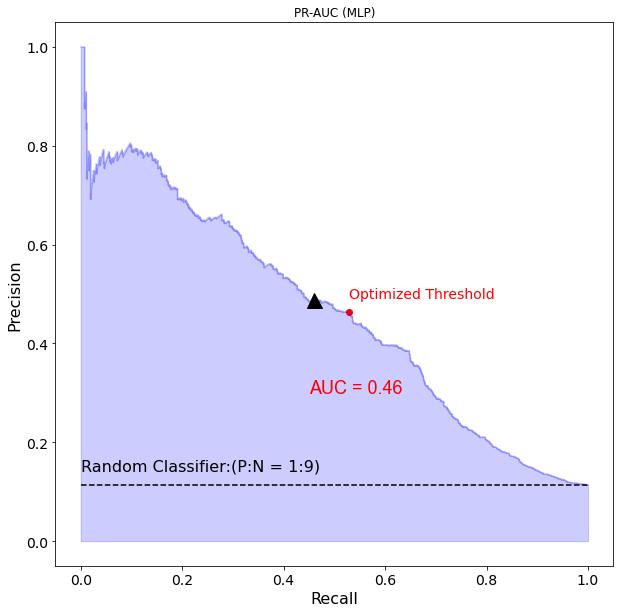

In [66]:
precision_recall_threshold(precision, recall, thresholds, y_test, y_pred_proba_mlp, t=0.5, plot_type='MLP',savefig='No')

### To find the optimal threshold and compare against a random classifier for the same imbalanced dataset we can also calculate the argmax based on F1 score over all the precision vs recall (without interpolation).

In [67]:
plot_pr_auc_thresholds(precision, recall, thresholds, y_test, y_pred_proba_mlp,plot_type='MLP')

## Precision-Recall Tradeoff

We would perform adjustment to the threshold in order to reduce the appearance of False Positive samples which are more harmful to our problem than the False Negatives.

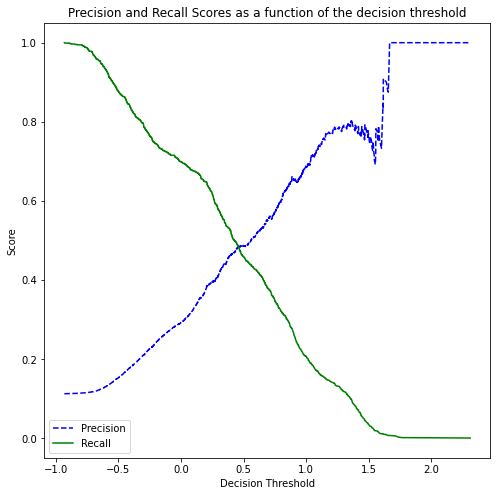

In [68]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

### F0.5-Measure

In [69]:
p_score = precision_score(y_test, y_pred_mlp)
r_score = recall_score(y_test, y_pred_mlp)
f = fbeta_score(y_test, y_pred_mlp, beta=0.5)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p_score, r_score, f))

Result: p=0.292, r=0.699, f=0.331


## Confusion matrix plot

To understand the contributions of each class we can plot a confusion matrix 

Define labels for both classes

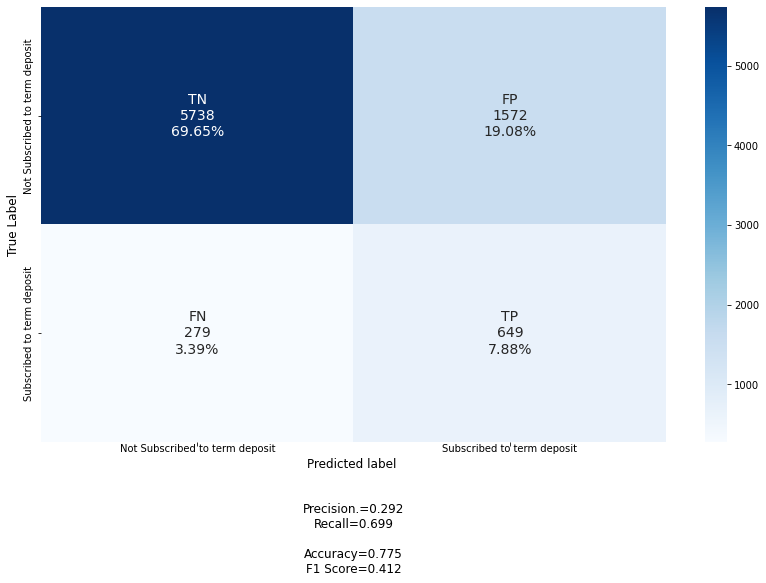

In [70]:
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
plot_confusion_matrix(conf_matrix, target_names= ['Not Subscribed to term deposit', 'Subscribed to term deposit'],
                     plot_type='mlp',savefig='No')

### Classification Report

In [28]:
target_names = ['Not Subscribed to term deposit','Subscribed to term deposit']

print(classification_report(y_test, y_pred_mlp, target_names=target_names))

                                precision    recall  f1-score   support

Not Subscribed to term deposit       0.95      0.78      0.86      7310
    Subscribed to term deposit       0.29      0.70      0.41       928

                      accuracy                           0.78      8238
                     macro avg       0.62      0.74      0.64      8238
                  weighted avg       0.88      0.78      0.81      8238



# SVM

Load hyperparameters (best model) from file

In [39]:
# Load SVM model from joblib file
svm_best_model = load(svm_best_model_filename) 

# Using pickle file
# with open('svm_best_model.pkl', 'rb') as handle:
#     svm_best_model = pkl.load(handle)

## Evaluate SVM trained model (Predict)

### Predict probabilities

In [40]:
y_pred_proba_svm = svm_best_model.predict_proba(X_test_unscaled)[:,1]

### Verify model pipeline

In [31]:
svm_best_model

Pipeline(steps=[('scaler', StandardScaler()),
                ('o',
                 SMOTE(k_neighbors=7, random_state=2, sampling_strategy=0.2)),
                ('ru',
                 RandomUnderSampler(random_state=2,
                                    sampling_strategy='majority')),
                ('svm',
                 SVC(C=679.9548167126571, class_weight='balanced',
                     gamma=0.00031756795756268224, probability=True,
                     random_state=2))])

### ROC-AUC Curve Plot

The ROC curve will show the classification results for the classifier prediction between the True Positive Rate in Y-axis (how many term subscriptions were correctly identified over the total number of term subscriptions) and the False Positive Rate in X-axis (ratio between non subscriptions the algorithm predicted as subscription but they are subscribed and total number of non subscriptions). We would expect the False Positive Rate as having a lower ratio giving the task because the campaign will not focus on clients

In [32]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_svm)

### Calculate the thresholds and plot ROC Curve

In [33]:
plot_roc_auc_thresholds(fpr, tpr, thresholds, y_test, y_pred_proba_svm, plot_type='SVM')

## Precision-Recall Curve (PR-AUC)

Compute precision, recall and thresholds based on predicted and actual targets

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_svm)

### Plot a basic PR-AUC Curve using a basic threshold (Threshold = 0.5)

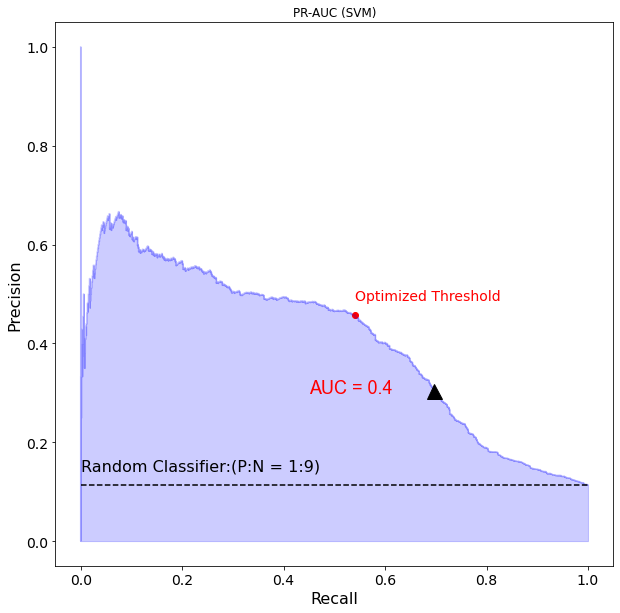

In [35]:
precision_recall_threshold(precision, recall, thresholds, y_test, y_pred_proba_svm, t=0.5, plot_type='SVM',savefig='No')

### And now we can plot Precision vs Recall as a function of the decision threshold

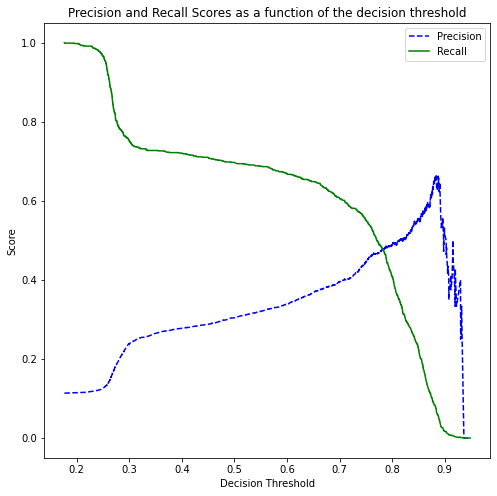

In [36]:
plot_precision_recall_vs_threshold(precision, recall, thresholds)

### To find the optimal threshold and compare against a random classifier for the same imbalanced dataset we can also calculate the argmax based on F1 score over all the precision vs recall points (without interpolation).

In [37]:
plot_pr_auc_thresholds(precision, recall, thresholds, y_test, y_pred_proba_svm,plot_type='SVM')

### F0.5-Measure

In [42]:
p_score = precision_score(y_test, svm_best_model.predict(X_test_unscaled)  )
r_score = recall_score(y_test, svm_best_model.predict(X_test_unscaled)  )
f = fbeta_score(y_test, svm_best_model.predict(X_test_unscaled)  , beta=0.5)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p_score, r_score, f))

Result: p=0.320, r=0.689, f=0.358


### Confusion Matrix

In [38]:
# Print the Score
#print("Test score: {0:.2f} %".format(100 * score))  
#astype(np.float32), y_train_model.astype(np.int64).squeeze(1)

# Predict the Labels using the reloaded Model
y_pred_svm = svm_best_model.predict(X_test_unscaled)  

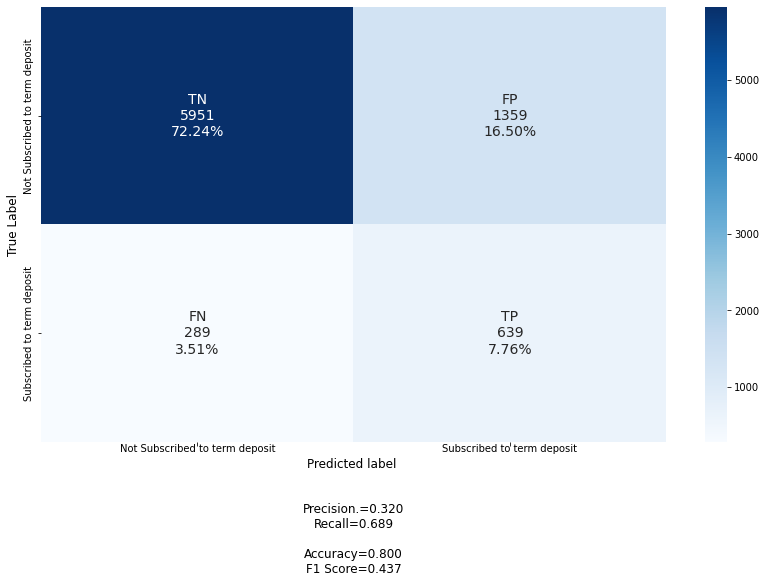

In [39]:
conf_matrix = confusion_matrix(y_test.ravel(), y_pred_svm)
plot_confusion_matrix(conf_matrix, target_names= ['Not Subscribed to term deposit', 'Subscribed to term deposit'],
                     plot_type='svm')

# Save to png

### Classification Report

In [40]:
target_names = ['Not Subscribed to term deposit','Subscribed to term deposit']

print(classification_report(y_test, y_pred_svm, target_names=target_names))

                                precision    recall  f1-score   support

Not Subscribed to term deposit       0.95      0.81      0.88      7310
    Subscribed to term deposit       0.32      0.69      0.44       928

                      accuracy                           0.80      8238
                     macro avg       0.64      0.75      0.66      8238
                  weighted avg       0.88      0.80      0.83      8238



## Algorithm comparison

### Conclusions of the algorithm comparison

- Based on the assumptions posed to our imbalanced dataset we conclude the SVM method performed better compared to MLP as opposed to better ROC-AUC results for MLP (0.80 vs 0.79). However, the results are similar and both accuracies are almost equal with a small advantage of SVM over MLP (0.80 vs 0.775).


- When we look at PR-AUC we can have a clear understanding of the high imbalance and both models did not perform well despite of a large improvement over a random classifier considering 1:9 ratio of imbalance as seen in both PR-AUC plots.


- From the confusion matrices we note the False Positive samples are larger in MLP (1572) than in SVM (1359) with a clear difference of samples misclassified. The number of False Negatives (679 for SVM and 689 for MLP) and True Positives (for SVM and for MLP) are approximately identical. In that regards as the objective he false positive samples there is a noticeable difference between and method. This could be related to parameters that for the MLP method controls the learning.